In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load the B0005.mat file
data = scipy.io.loadmat("B0005.mat")

# Check what keys are in the data
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'B0005'])


In [2]:
# Access the actual data under 'B0005' key
battery = data['B0005'][0][0]

# Show the field names inside B0005 (e.g., cycle, voltage_measured, capacity, etc.)
print("Fields in B0005:", battery.dtype.names)


Fields in B0005: ('cycle',)


In [3]:
# Get all cycle data (as a list of dict-like entries)
cycles = battery['cycle'][0]

# Check how many cycles are recorded
print("Total cycles:", len(cycles))

# Show what's inside the first cycle
print("Fields in one cycle:", cycles[0].dtype.names)


Total cycles: 616
Fields in one cycle: ('type', 'ambient_temperature', 'time', 'data')


In [4]:
# Find first 'charge' cycle
for i, cycle in enumerate(cycles):
    if cycle['type'][0] == 'charge':
        print(f"Cycle #{i+1} data fields:", cycle['data'].dtype.names)
        break


Cycle #1 data fields: ('Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge', 'Time')


In [5]:
cycle_nums = []
capacities = []

for i, cycle in enumerate(cycles):
    if cycle['type'][0] == 'charge':
        data = cycle['data'][0, 0]
        current = data['Current_charge'][0]
        time = data['Time'][0]  # in seconds

        # Convert time to seconds (some may be float strings)
        try:
            time = [float(t) for t in time]
        except:
            time = time.astype(float)

        # Calculate delta_t and area under current curve
        delta_t = np.diff(time)
        current_avg = (current[1:] + current[:-1]) / 2
        capacity = np.sum(current_avg * delta_t) / 3600  # Convert to Ah

        cycle_nums.append(i + 1)
        capacities.append(capacity)

df = pd.DataFrame({
    'Cycle': cycle_nums,
    'Capacity (Ah)': capacities
})

df.head()


,Cycle,Capacity (Ah)
0,1,0.770778
1,3,1.865272
2,5,1.858042
3,7,1.850149
4,9,1.848153


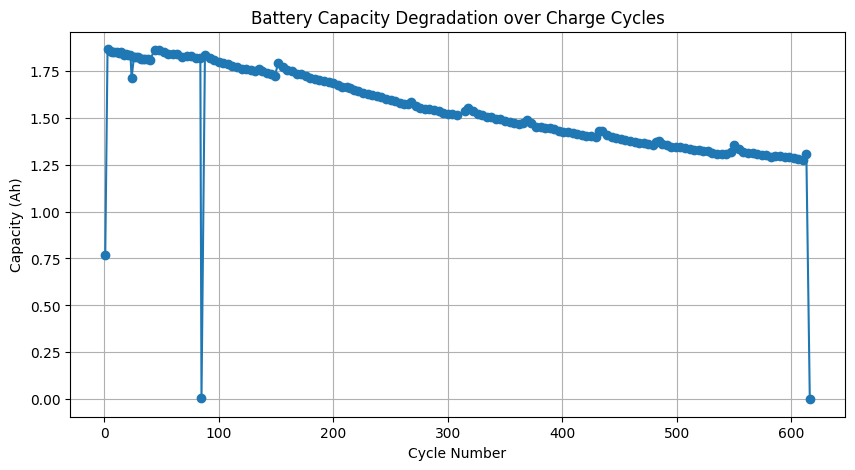

In [6]:
# Visualization cell
plt.figure(figsize=(10, 5))
plt.plot(df['Cycle'], df['Capacity (Ah)'], marker='o', linestyle='-')
plt.xlabel("Cycle Number")
plt.ylabel("Capacity (Ah)")
plt.title("Battery Capacity Degradation over Charge Cycles")
plt.grid(True)
plt.show()


In [7]:
initial_capacity = df['Capacity (Ah)'].max()
df['SOH (%)'] = (df['Capacity (Ah)'] / initial_capacity) * 100



# Show a preview
df.head()


,Cycle,Capacity (Ah),SOH (%)
0,1,0.770778,41.322550
1,3,1.865272,100.000000
2,5,1.858042,99.612425
3,7,1.850149,99.189259
4,9,1.848153,99.082267


In [8]:
# Create sequences
def create_sequences(data, seq_len=5):
    xs = []
    ys = []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Only use SOH (%) column
soh_values = df['SOH (%)'].values
X, y = create_sequences(soh_values, seq_len=5)

print("Input sequence shape:", X.shape)
print("Target shape:", y.shape)


Input sequence shape: (165, 5)
Target shape: (165,)


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class SOHDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
dataset = SOHDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [10]:
import torch.nn as nn

class SOHPredictor(nn.Module):
    def __init__(self):
        super(SOHPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SOHPredictor()
print(model)


SOHPredictor(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [11]:
# Normalize target (SOH) values
soh_min = y.min()
soh_max = y.max()
y_norm = (y - soh_min) / (soh_max - soh_min)

# Replace target in TensorDataset
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                         torch.tensor(y_norm, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [19]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 130
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")


Epoch [10/130], Loss: 0.1014
Epoch [20/130], Loss: 0.1381
Epoch [30/130], Loss: 0.1986
Epoch [40/130], Loss: 0.1089
Epoch [50/130], Loss: 0.1282
Epoch [60/130], Loss: 0.1336
Epoch [70/130], Loss: 0.1201
Epoch [80/130], Loss: 0.2064
Epoch [90/130], Loss: 0.2805
Epoch [100/130], Loss: 0.2400
Epoch [110/130], Loss: 0.1032
Epoch [120/130], Loss: 0.2342
Epoch [130/130], Loss: 0.1394


In [20]:
# Set model to evaluation mode
model.eval()

# Get predictions for the entire dataset (or use a test set if available)
with torch.no_grad():
    inputs = torch.tensor(X, dtype=torch.float32)
    predicted = model(inputs).squeeze().numpy()

# De-normalize
predicted_soh = predicted * (soh_max - soh_min) + soh_min


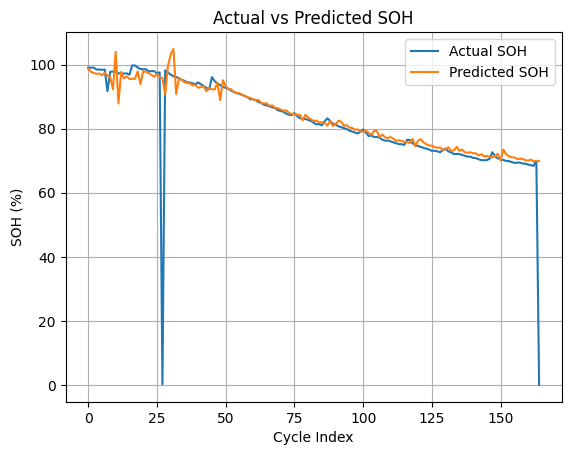

In [21]:
import matplotlib.pyplot as plt

plt.plot(y, label='Actual SOH')
plt.plot(predicted_soh, label='Predicted SOH')
plt.xlabel('Cycle Index')
plt.ylabel('SOH (%)')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# --- RUL Calculation ---

# Define threshold for end-of-life
soh_threshold = 80.0  # in %

# Calculate RUL: for each cycle, find how many steps until predicted SOH drops below 80%
rul = []
for i in range(len(predicted_soh)):
    remaining = 0
    for j in range(i, len(predicted_soh)):
        if predicted_soh[j] >= soh_threshold:
            remaining += 1
        else:
            break
    rul.append(remaining)

# Add RUL to DataFrame (for matching)
df_rul = df.iloc[5:].copy()  # Since first 5 cycles are used for sequence input
df_rul['Predicted SOH (%)'] = predicted_soh
df_rul['Predicted RUL (cycles)'] = rul

# Show sample
df_rul.head()


,Cycle,Capacity (Ah),SOH (%),Predicted SOH (%),Predicted RUL (cycles)
5,11,1.848912,99.122922,98.746481,97
6,13,1.847459,99.045039,97.801044,96
7,15,1.848649,99.108851,97.377961,95
8,17,1.837080,98.488584,97.152659,94
9,19,1.837181,98.494035,97.265756,93


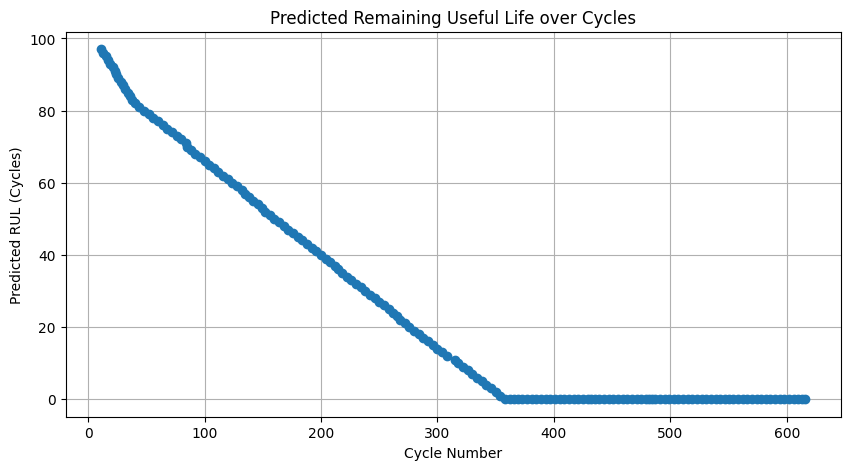

In [23]:
# --- RUL Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(df_rul['Cycle'], df_rul['Predicted RUL (cycles)'], marker='o', linestyle='-')
plt.xlabel("Cycle Number")
plt.ylabel("Predicted RUL (Cycles)")
plt.title("Predicted Remaining Useful Life over Cycles")
plt.grid(True)
plt.show()


In [24]:
X_tensor = torch.tensor(X, dtype=torch.float32)
predicted_soh = model(X_tensor).detach().numpy()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compare actual and predicted SOH
mae = mean_absolute_error(y, predicted_soh)
rmse = np.sqrt(mean_squared_error(y, predicted_soh))
r2 = r2_score(y, predicted_soh)

print(f"\n📊 Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Square Error): {rmse:.2f}")
print(f"R² Score (Closer to 1 is better): {r2:.2f}")



📊 Model Evaluation Metrics:
MAE  (Mean Absolute Error): 81.89
RMSE (Root Mean Square Error): 83.00
R² Score (Closer to 1 is better): -35.65
